# Train Some Example Models

## Imports


In [1]:
import os
import sys
os.getcwd()
sys.path.append('../preprocess')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import models
from torchsummary import summary
from solver import Solver

# Dataset
# from preprocess.GeoGuessrDataset import GeoGuessrDataset
from GeoGuessrDataset import GeoGuessrDataset, ToTensor


import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tnrange

%matplotlib inline

# Enable autoreloading of imported modules.
%load_ext autoreload
%autoreload 2

In [54]:
# Check GPU support on your machine.
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)

root_dir = r"C:\Users\valdr\datasets\geoguessr_dataset"
HEIGHT = 512
WIDTH = 2560

cuda:0


In [53]:
torch.cuda.get_device_name(device=None)

'NVIDIA GeForce RTX 3050 Laptop GPU'

## Sources:
- AUTOMATIC MIXED PRECISION: https://pytorch.org/tutorials/recipes/recipes/amp_recipe.html
- TRANSFER LEARNING FOR COMPUTER VISION TUTORIAL: https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

In [105]:
import torch
import torch.nn as nn

class GeoGuessrNet(nn.Module):
    def __init__(self):
        super(GeoGuessrNet, self).__init__()
        
        # Define the convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=16, stride=6, padding=1)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=16, stride=6, padding=1)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=6, padding=1)
        
        
        # Define the fully-connected layers
        self.fc1 = nn.Linear(160 , 200)  # modified to have the correct input size
        self.fc2 = nn.Linear(200, 10)
        self.fc3 = nn.Linear(10, 32768)
        # self.fc2 = nn.Linear(1024, 32768)  # output size is still 32768
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        
        # x = torch.flatten(x, 1)
        x = x.view(x.size(0), -1)
        
        x = self.fc1(x)
        x = self.fc2(x) 
        x = self.fc3(x)
        return x


In [6]:
import torch
import torch.nn as nn

class GeoGuessrNet_2(nn.Module):
    def __init__(self):
        super(GeoGuessrNet_2, self).__init__()
        
        # Define the convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=2, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=2, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.conv5 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=2, padding=1)
        self.bn5 = nn.BatchNorm2d(512)
        
        # Define the fully-connected layers
        self.fc1 = nn.Linear(512 * 256 * 512, 1024)
        self.bn6 = nn.BatchNorm1d(1024)
        self.drop1 = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(1024, 512)
        self.bn7 = nn.BatchNorm1d(512)
        self.drop2 = nn.Dropout(p=0.5)
        self.fc3 = nn.Linear(512, 256)
        self.bn8 = nn.BatchNorm1d(256)
        self.drop3 = nn.Dropout(p=0.5)
        self.fc4 = nn.Linear(256, 128)
        self.bn9 = nn.BatchNorm1d(128)
        self.drop4 = nn.Dropout(p=0.5)
        self.fc5 = nn.Linear(128, 64)
        self.bn10 = nn.BatchNorm1d(64)
        self.drop5 = nn.Dropout(p=0.5)
        self.fc6 = nn.Linear(64, 32)
        self.bn11 = nn.BatchNorm1d(32)
        self.drop6 = nn.Dropout(p=0.5)
        self.fc7 = nn.Linear(32, 16)
        self.bn12 = nn

    

In [26]:
class GeoGuessrNet_3(nn.Module):
    def __init__(self, num_classes = 32768):
        super(GeoGuessrNet_3, self).__init__()

        # Define the convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)

        # Define the pooling layers
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Define the batch normalization layers
        self.batch_norm1 = nn.BatchNorm2d(num_features=16)
        self.batch_norm2 = nn.BatchNorm2d(num_features=32)
        self.batch_norm3 = nn.BatchNorm2d(num_features=64)

        # Define the fully-connected layers
        self.fc1 = nn.Linear(in_features=2621440, out_features=num_classes)
        # self.fc2 = nn.Linear(in_features=512, out_features=num_classes)

    def forward(self, x):
        # Apply the convolutional layers and pooling layers
        x = self.pool(self.batch_norm1(torch.relu(self.conv1(x))))
        x = self.pool(self.batch_norm2(torch.relu(self.conv2(x))))
        x = self.pool(self.batch_norm3(torch.relu(self.conv3(x))))

        # Flatten the output of the convolutional layers
        print(x.size(0))
        x = x.view(x.size(0), -1)

        # Apply the fully-connected layers
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)

        return x



### Define Model and Summary

In [104]:

model = GeoGuessrNet()
# model = GeoGuessrNet()
# model = GeoGuessrNet_3()
# model = GeoGuessrNet_4()
model = model.to(device)
summary(model, (3,HEIGHT, WIDTH))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 8, 84, 425]           6,152
            Conv2d-2           [-1, 16, 12, 69]          32,784
            Conv2d-3            [-1, 32, 2, 12]           4,640
            Linear-4                  [-1, 200]         153,800
            Linear-5                   [-1, 10]           2,010
            Linear-6                [-1, 32768]         360,448
Total params: 559,834
Trainable params: 559,834
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 15.00
Forward/backward pass size (MB): 2.54
Params size (MB): 2.14
Estimated Total Size (MB): 19.67
----------------------------------------------------------------


In [28]:
343597383680  * 1e-9

343.59738368

### Define Optimization

In [99]:
# Define a loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Define the data transformation
transform = transforms.Compose([
    transforms.ToTensor(),  # convert images to tensors
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),  # normalize images
    transforms.Resize((250, 1000))
])

### Load Dataset

In [100]:
# Load the dataset and split it into training and validation sets

dataset = GeoGuessrDataset(csv_file='../preprocess/coordinates_europe.csv',
                                    root_dir=root_dir, transform=transform)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# Define the dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 torch.Size([3, 250, 1000]) tensor([0, 0, 0,  ..., 0, 0, 0])
1 torch.Size([3, 250, 1000]) tensor([0, 0, 0,  ..., 0, 0, 0])
2 torch.Size([3, 250, 1000]) tensor([0, 0, 0,  ..., 0, 0, 0])
3 torch.Size([3, 250, 1000]) tensor([0, 0, 0,  ..., 0, 0, 0])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4 torch.Size([3, 250, 1000]) tensor([0, 0, 0,  ..., 0, 0, 0])
5 torch.Size([3, 250, 1000]) tensor([0, 0, 0,  ..., 0, 0, 0])
6 torch.Size([3, 250, 1000]) tensor([0, 0, 0,  ..., 0, 0, 0])
7 torch.Size([3, 250, 1000]) tensor([0, 0, 0,  ..., 0, 0, 0])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


8 torch.Size([3, 250, 1000]) tensor([0, 0, 0,  ..., 0, 0, 0])
9 torch.Size([3, 250, 1000]) tensor([0, 0, 0,  ..., 0, 0, 0])


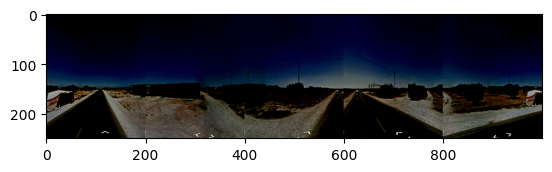

In [101]:

for i in range(10):
    sample = dataset[i]
    plt.imshow(sample["image"].permute(1, 2, 0))
    print(i, sample['image'].shape, sample['geohash'])

In [111]:
for i, batch in enumerate(train_dataloader):
    x, y = batch["image"], batch["geohash"]
    print(x.shape, y.shape)
    break
    
len(dataset)

torch.Size([32, 3, 250, 1000]) torch.Size([32, 32768])


40797

### Train Model

In [112]:
model = GeoGuessrNet()
model = model.to(device)
solver = Solver(model,{'train':train_dataset,'val':val_dataset},optimizer="Adam",batch_size=3, use_amp=True)
history =solver.train(num_epochs=5)

  0%|          | 0/5 [00:00<?, ?it/s]

TypeError: conv2d() received an invalid combination of arguments - got (str, Parameter, Parameter, tuple, tuple, tuple, int), but expected one of:
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, tuple of ints padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: ([31;1mstr[0m, [31;1mParameter[0m, [31;1mParameter[0m, [31;1mtuple[0m, [31;1mtuple[0m, [31;1mtuple[0m, [32;1mint[0m)
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, str padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: ([31;1mstr[0m, [31;1mParameter[0m, [31;1mParameter[0m, [31;1mtuple[0m, [31;1mtuple[0m, [31;1mtuple[0m, [32;1mint[0m)


In [30]:
# Train the model
num_epochs = 10
for epoch in (pbar := tnrange(num_epochs)):
    # Training
    model.train()
    train_loss = 0.0
    for idx, batch in enumerate(train_dataloader):
        # Convert images (input) to float because it is a ByteTensor. Why is it a ByteTensor?
        images, labels = batch["image"].float(), batch["geohash"].float()
        
        # Move the data to the device
        images = images.to(device)
        labels = labels.to(device)
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass
        loss.backward()
        
        # Update the weights
        optimizer.step()
        
        # Accumulate the training loss
        train_loss += loss.item() * images.size(0)
        
    pbar.set_description(f'Epoch: {epoch + 1}  Loss: {loss.item():.5f}')    
        

  0%|          | 0/10 [00:00<?, ?it/s]

RuntimeError: CUDA out of memory. Tried to allocate 480.00 MiB (GPU 0; 4.00 GiB total capacity; 3.26 GiB already allocated; 0 bytes free; 3.28 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

### Validation

In [ ]:
# Validation
model.eval()
val_loss = 0.0
with torch.no_grad():
    for images, labels in val_dataloader:
        # Move the data to the device
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        prediction = torch.argmax(outputs.data, 1)

        # Accumulate the validation loss                                
        val_loss += loss.item() * images.size(0)                        


# Print the epoch loss                                                  
train_loss = train_loss / len(train_dataloader.dataset)                 
val_loss = val_loss / len(val_dataloader.dataset)